<a href="https://colab.research.google.com/github/shrutikaur/Phishing-URL-Detection/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning Based Phishing Detection System using URL's**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import pandas as pd
import io

data = pd.read_csv(io.BytesIO(uploaded['index.csv']))
print(data)


In [ ]:
data.head()

,rec_id,url,website,result,created_date
0,1,http://intego3.info/EXEL/index.php,1613573972338075.html,1,2/17/2021
1,2,https://www.mathopenref.com/segment.html,1635698138155948.html,0,10/31/2021
2,3,https://www.computerhope.com/issues/ch000254.htm,1635699228889266.html,0,10/31/2021
3,4,https://www.investopedia.com/terms/n/next-elev...,1635750062162701.html,0,11-01-2021
4,5,https://jobs.emss.org.uk/lcc.aspx,161356510250721.html,0,2/17/2021


In [ ]:
data.shape

(80000, 5)

In [ ]:
data.columns

Index(['rec_id', 'url', 'website', 'result', 'created_date'], dtype='object')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   rec_id        80000 non-null  int64 
 1   url           80000 non-null  object
 2   website       80000 non-null  object
 3   result        80000 non-null  int64 
 4   created_date  80000 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.1+ MB


In [ ]:
data.nunique()

rec_id          80000
url             79848
website         80000
result              2
created_date      109
dtype: int64

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
rec_id,80000.0,40000.500,23094.155105,1.0,20000.75,40000.5,60000.25,80000.0
result,80000.0,0.375,0.484126,0.0,0.00,0.0,1.00,1.0


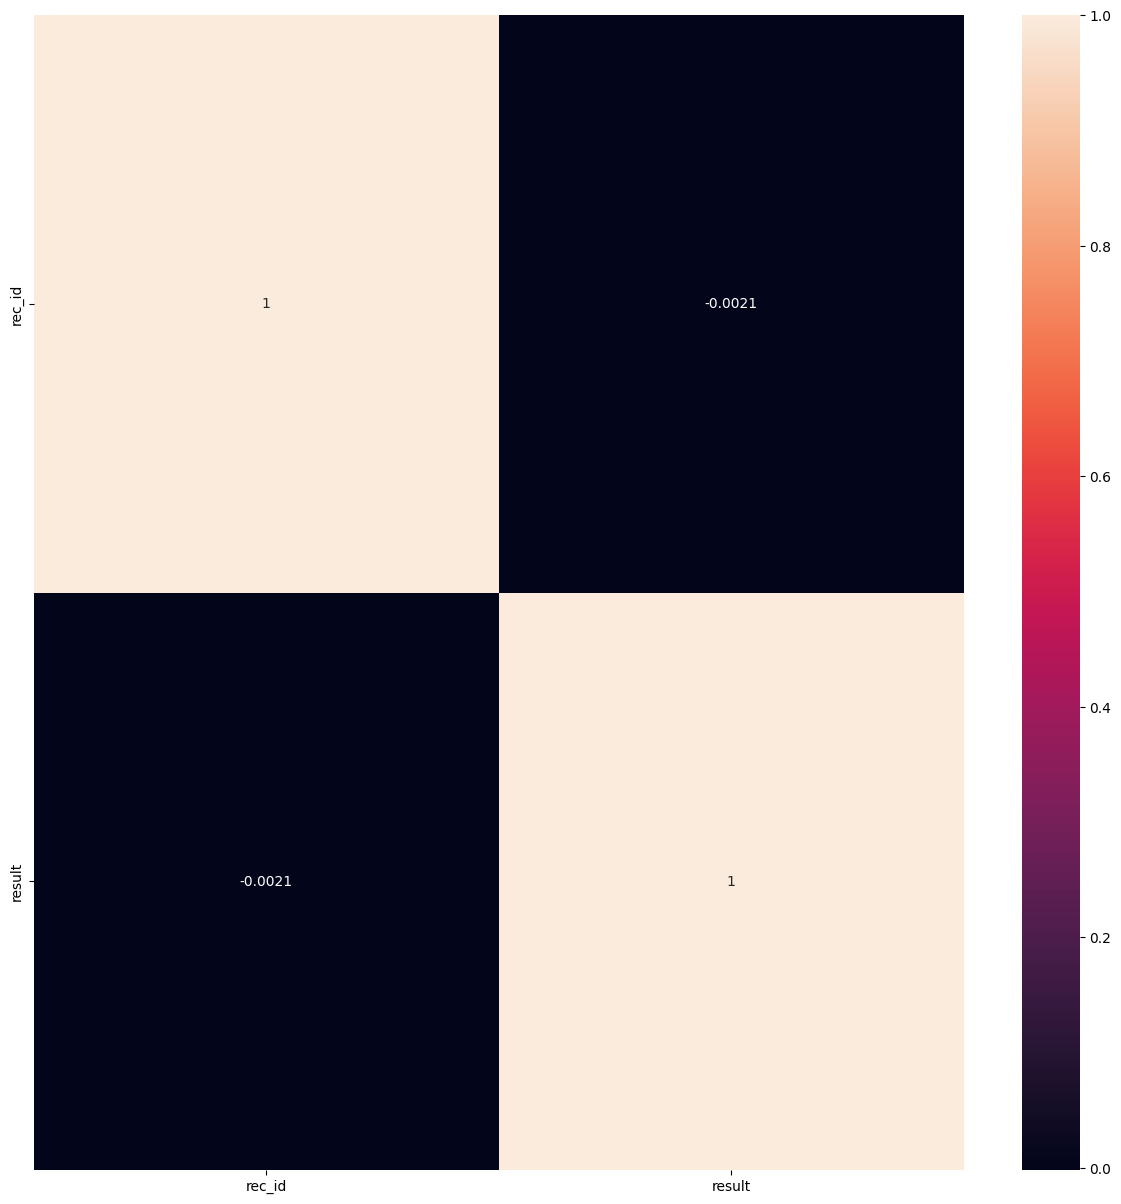

In [ ]:
#Correlation heatmap
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(), annot=True)
plt.show()

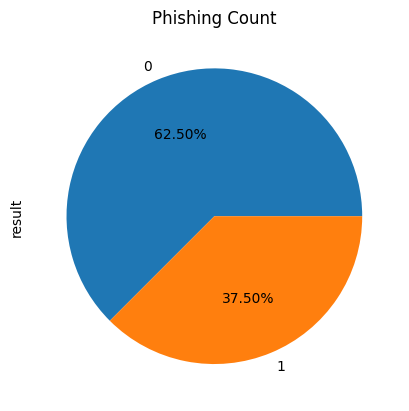

In [ ]:
data['result'].value_counts().plot(kind='pie',autopct='%1.2f%%')
plt.title("Phishing Count")
plt.show()

**Feature** **Extraction**

In [ ]:
from urllib.parse import urlparse,urlencode
import ipaddress
import re

In [ ]:
# 1.Domain of the URL (Domain)
def getDomain(url):
  domain = urlparse(url).netloc
  if re.match(r"^www.",domain):
	       domain = domain.replace("www.","")
  return domain


In [ ]:
# 2.Checks for IP address in URL (Have_IP)
def havingIP(url):
  try:
    ipaddress.ip_address(url)
    ip = 1
  except:
    ip = 0
  return ip


In [ ]:
# 3.Checks the presence of @ in URL (Have_At)
def haveAtSign(url):
  if "@" in url:
    at = 1
  else:
    at = 0
  return at

In [ ]:
# 4.Finding the length of URL and categorizing (URL_Length)
def getLength(url):
  if len(url) < 54:
    length = 0
  else:
    length = 1
  return length

In [ ]:
# 5.Gives number of '/' in URL (URL_Depth)
def getDepth(url):
  s = urlparse(url).path.split('/')
  depth = 0
  for j in range(len(s)):
    if len(s[j]) != 0:
      depth = depth+1
  return depth

In [ ]:
# 6.Checking for redirection '//' in the url (Redirection)
def redirection(url):
  pos = url.rfind('//')
  if pos > 6:
    if pos > 7:
      return 1
    else:
      return 0
  else:
    return 0

In [ ]:
# 7.Existence of “HTTPS” Token in the Domain Part of the URL (https_Domain)
def httpDomain(url):
  domain = urlparse(url).netloc
  if 'https' in domain:
    return 1
  else:
    return 0

In [ ]:
#listing shortening services
shortening_services = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                      r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                      r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                      r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                      r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                      r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                      r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
                      r"tr\.im|link\.zip\.net"

In [ ]:
# 8. Checking for Shortening Services in URL (Tiny_URL)
def tinyURL(url):
    match=re.search(shortening_services,url)
    if match:
        return 1
    else:
        return 0

In [ ]:
# 9.Checking for Prefix or Suffix Separated by (-) in the Domain (Prefix/Suffix)
def prefixSuffix(url):
    if '-' in urlparse(url).netloc:
        return 1            # phishing
    else:
        return 0            # legitimate

In [ ]:
#Domain Based Feature
!pip install python-whois

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-whois: filename=python_whois-0.8.0-py3-none-any.whl size=103262 sha256=7b02ffa81632a41cee4f82cc41310f3a43b3f711910f0d69c363b8c572d5e9ff
  Stored in directory: /root/.cache/pip/wheels/10/f1/87/145023b9a206e2e948be6480c61ef3fd3dbb81ef11b6977782
Successfully built python-whois


In [ ]:
# importing required packages for this section
import re
from bs4 import BeautifulSoup
import whois
import urllib
import urllib.request
from datetime import datetime

In [ ]:
# 12.Web traffic (Web_Traffic)
def web_traffic(url):
  try:
    #Filling the whitespaces in the URL if any
    url = urllib.parse.quote(url)
    rank = BeautifulSoup(urllib.request.urlopen("http://data.alexa.com/data?cli=10&dat=s&url=" + url).read(), "xml").find(
        "REACH")['RANK']
    rank = int(rank)
  except TypeError:
        return 1
  if rank <100000:
    return 1
  else:
    return 0

In [ ]:
# 13.Survival time of domain: The difference between termination time and creation time (Domain_Age)
def domainAge(domain_name):
  creation_date = domain_name.creation_date
  expiration_date = domain_name.expiration_date
  if (isinstance(creation_date,str) or isinstance(expiration_date,str)):
    try:
      creation_date = datetime.strptime(creation_date,'%Y-%m-%d')
      expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
    except:
      return 1
  if ((expiration_date is None) or (creation_date is None)):
      return 1
  elif ((type(expiration_date) is list) or (type(creation_date) is list)):
      return 1
  else:
    ageofdomain = abs((expiration_date - creation_date).days)
    if ((ageofdomain/30) < 6):
      age = 1
    else:
      age = 0
  return age

In [ ]:
# 14.End time of domain: The difference between termination time and current time (Domain_End)
def domainEnd(domain_name):
  expiration_date = domain_name.expiration_date
  if isinstance(expiration_date,str):
    try:
      expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
    except:
      return 1
  if (expiration_date is None):
      return 1
  elif (type(expiration_date) is list):
      return 1
  else:
    today = datetime.now()
    end = abs((expiration_date - today).days)
    if ((end/30) < 6):
      end = 0
    else:
      end = 1
  return end

In [ ]:
#HTML based features
import requests

In [ ]:
# 15. IFrame Redirection (iFrame)
def iframe(response):
  if response == "":
      return 1
  else:
      if re.findall(r"[|]", response.text):
          return 0
      else:
          return 1

In [ ]:
# 16.Checks the effect of mouse over on status bar (Mouse_Over)
def mouseOver(response):
  if response == "" :
    return 1
  else:
    if re.findall("", response.text):
      return 1
    else:
      return 0

In [ ]:
# 17.Checks the status of the right click attribute (Right_Click)
def rightClick(response):
  if response == "":
    return 1
  else:
    if re.findall(r"event.button ?== ?2", response.text):
      return 0
    else:
      return 1

In [ ]:
# 18.Checks the number of forwardings (Web_Forwards)
def forwarding(response):
  if response == "":
    return 1
  else:
    if len(response.history) <= 2:
      return 0
    else:
      return 1

In [ ]:
#Function to extract features
def featureExtraction(urls,label):

  features = []
  #Address bar based features (10)
  features.append(getDomain(urls))
  features.append(havingIP(urls))
  features.append(haveAtSign(urls))
  features.append(getLength(urls))
  features.append(getDepth(urls))
  features.append(redirection(urls))
  features.append(httpDomain(urls))
  features.append(tinyURL(urls))
  features.append(prefixSuffix(urls))

  #Domain based features (4)
  dns = 0
 # try:
  #  domain_name = whois.whois(urlparse(urls).netloc)
  #except:
   # dns = 1

  #features.append(dns)
  #features.append(web_traffic(urls))
  #features.append(1 if dns == 1 else domainAge(domain_name))
  #features.append(1 if dns == 1 else domainEnd(domain_name))

  # HTML & Javascript based features (4)
  try:
    response = requests.get(urls)
  except:
    response = ""
  features.append(iframe(response))
  features.append(mouseOver(response))
  features.append(rightClick(response))
  features.append(forwarding(response))
  features.append(label)

  return features

In [ ]:
#Extracting the feautres & storing them in a list
legi_features = []
label = 0

for i in range(0, 80000):
  urls = data['url'][i]
  legi_features.append(featureExtraction(urls,label))

Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
Error trying to connect to socket: closing socket - [Errno 111] Connection refused


In [ ]:
#converting the list to dataframe
feature_names = ['Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth','Redirection',
                      'https_Domain', 'TinyURL', 'Prefix/Suffix', 'DNS_Record', 'Web_Traffic',
                      'Domain_Age', 'Domain_End', 'iFrame', 'Mouse_Over','Right_Click', 'Web_Forwards', 'Label']

legitimate = pd.DataFrame(legi_features, columns= feature_names)
legitimate.head()

In [ ]:
legitimate.tail()

In [ ]:
legitimate.shape

In [ ]:
#Plotting the data distribution
legitimate.hist(bins = 50,figsize = (15,15))
plt.show()

In [ ]:
X = data.drop(['url'], axis=1)
y = data['url']

In [ ]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
# check the shape of X_train and X_test
X_train.shape, X_test.shape

In [ ]:
# check data types in X_train
X_train.dtypes

In [ ]:
# display categorical variables
categorical = [col for col in X_train.columns if X_train[col].dtypes == 'O']
categorical

In [ ]:
# display numerical variables

numerical = [col for col in X_train.columns if X_train[col].dtypes != 'O']

numerical

In [ ]:
# print percentage of missing values in the categorical variables in training set

X_train[categorical].isnull().mean()

In [ ]:
# print categorical variables with missing data

for col in categorical:
    if X_train[col].isnull().mean()>0:
        print(col, (X_train[col].isnull().mean()))

In [ ]:
# check missing values in categorical variables in X_train

X_train[categorical].isnull().sum()

In [ ]:
# check missing values in categorical variables in X_test

X_test[categorical].isnull().sum()

In [ ]:
# print categorical variables

categorical

In [ ]:
X_train[categorical].head()

In [ ]:
pip install category-encoders

In [ ]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import pandas as pd
import io

data = pd.read_csv(io.BytesIO(uploaded['index.csv']))
print(data)


In [ ]:
# Choose target and features
y = data.url
features = ['rec_id', 'url', 'website', 'result', 'created_date']
X = data[features]

from sklearn.model_selection import train_test_split

# split data into training and validation data, for both features and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(train_X, train_y)
melb_preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, melb_preds))

In [ ]:
#Function to extract features
def featureExtraction(url,label):

  features = []
  #Address bar based features (10)
  features.append(getDomain(url))
  features.append(havingIP(url))
  features.append(haveAtSign(url))
  features.append(getLength(url))
  features.append(getDepth(url))
  features.append(redirection(url))
  features.append(httpDomain(url))
  features.append(tinyURL(url))
  features.append(prefixSuffix(url))

  #Domain based features (4)
  dns = 0
  try:
    domain_name = whois.whois(urlparse(url).netloc)
  except:
    dns = 1

  features.append(dns)
  features.append(web_traffic(url))
  features.append(1 if dns == 1 else domainAge(domain_name))
  features.append(1 if dns == 1 else domainEnd(domain_name))

  # HTML & Javascript based features (4)
  try:
    response = requests.get(url)
  except:
    response = ""
  features.append(iframe(response))
  features.append(mouseOver(response))
  features.append(rightClick(response))
  features.append(forwarding(response))
  features.append(label)

  return features
